<a href="https://colab.research.google.com/github/abhi220501/EE769-Cource-Project/blob/main/ML_project_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defo.zip

In [ ]:
pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsampler import ImbalancedDatasetSampler

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/dataset_defo/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=4, 
                                              num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FileNotFoundError: ignored

In [ ]:
print(device)

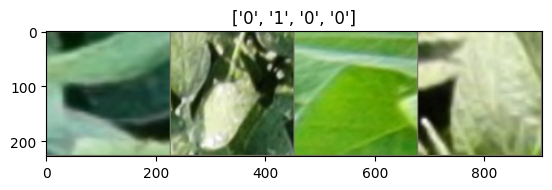

In [ ]:
# Visualize a few images
# Let's visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
# Training the model:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 266MB/s]


In [ ]:
print(model_conv)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model_conv.parameters():
    param.requires_grad = False
from collections import OrderedDict

# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model_conv.classifier.in_features
model_conv.classifier =  nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, 4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096, 1024)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc4', nn.Linear(512, 2))
     ]))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [ ]:
# 1 to 10 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3758 Acc: 0.8055
test Loss: 0.3569 Acc: 0.8274

Epoch 1/9
----------
train Loss: 0.3792 Acc: 0.8041
test Loss: 0.3642 Acc: 0.8211

Epoch 2/9
----------
train Loss: 0.3766 Acc: 0.8054
test Loss: 0.3519 Acc: 0.8260

Epoch 3/9
----------
train Loss: 0.3739 Acc: 0.8058
test Loss: 0.3492 Acc: 0.8327

Epoch 4/9
----------
train Loss: 0.3767 Acc: 0.8043
test Loss: 0.3584 Acc: 0.8271

Epoch 5/9
----------
train Loss: 0.3789 Acc: 0.8034
test Loss: 0.3616 Acc: 0.8244

Epoch 6/9
----------
train Loss: 0.3749 Acc: 0.8059
test Loss: 0.3420 Acc: 0.8365

Epoch 7/9
----------
train Loss: 0.3753 Acc: 0.8067
test Loss: 0.3616 Acc: 0.8235

Epoch 8/9
----------
train Loss: 0.3776 Acc: 0.8036
test Loss: 0.3557 Acc: 0.8286

Epoch 9/9
----------
train Loss: 0.3760 Acc: 0.8070
test Loss: 0.3489 Acc: 0.8320

Training complete in 63m 44s
Best val Acc: 0.836483


In [ ]:
#For saving the model
model_conv.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_conv.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_conv.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_conv.state_dict(),
                  'class_to_idx': model_conv.class_to_idx,
                  'epoch': model_conv.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_alexnet_6_withIDS.pth')

In [ ]:
# for loading the model
#loading the weights in the network
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_alexnet_6_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
# 11 to 20 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3767 Acc: 0.8059
test Loss: 0.3590 Acc: 0.8272

Epoch 1/9
----------
train Loss: 0.3768 Acc: 0.8042
test Loss: 0.3522 Acc: 0.8273

Epoch 2/9
----------
train Loss: 0.3749 Acc: 0.8079
test Loss: 0.3660 Acc: 0.8265

Epoch 3/9
----------
train Loss: 0.3758 Acc: 0.8052
test Loss: 0.3594 Acc: 0.8279

Epoch 4/9
----------
train Loss: 0.3764 Acc: 0.8064
test Loss: 0.3541 Acc: 0.8276

Epoch 5/9
----------
train Loss: 0.3747 Acc: 0.8058
test Loss: 0.3696 Acc: 0.8253

Epoch 6/9
----------
train Loss: 0.3750 Acc: 0.8070
test Loss: 0.3641 Acc: 0.8234

Epoch 7/9
----------
train Loss: 0.3762 Acc: 0.8067
test Loss: 0.3550 Acc: 0.8286

Epoch 8/9
----------
train Loss: 0.3782 Acc: 0.8024
test Loss: 0.3605 Acc: 0.8242

Epoch 9/9
----------
train Loss: 0.3752 Acc: 0.8064
test Loss: 0.3596 Acc: 0.8314

Training complete in 62m 41s
Best val Acc: 0.831391


In [ ]:
#For saving the model
model_conv.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_conv.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_conv.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_conv.state_dict(),
                  'class_to_idx': model_conv.class_to_idx,
                  'epoch': model_conv.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_alexnet_20_withIDS.pth')

In [ ]:
# for loading the model
#loading the weights in the network
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_alexnet_20_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#Testing
from torch.autograd import Variable

def test(model, dataloaders, device):
    model.eval()
    accuracy = 0
      
    preds = []
    actual = []
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        images, labels = images.to(device), labels.to(device)
          
        output = model.forward(images)
        ps = torch.exp(output)
        preds.append(np.array(ps.max(1)[1].cpu()))
        actual.append(np.array(labels.data.cpu()))
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    preds = np.array(preds, dtype=object)
    actual = np.array(actual, dtype=object)
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))
    return np.concatenate(preds), np.concatenate(actual)

In [ ]:
preds_conv, actual_conv = test(model_conv, dataloaders, device)
preds_conv

Testing Accuracy: 0.830


array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

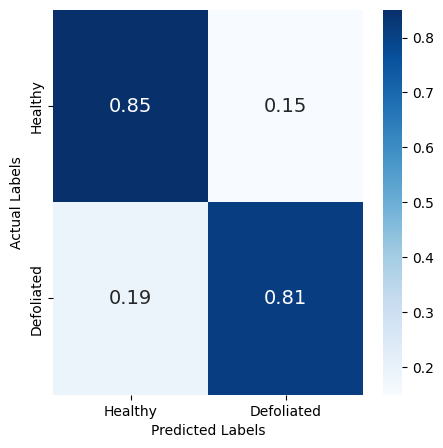

In [ ]:
#For fine tuned on conv net only
cm = confusion_matrix(preds_conv, actual_conv, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#Fine tuning on conv net

print(f1_score(actual_conv, preds_conv, average="binary"))
print(precision_score(actual_conv, preds_conv, average="binary"))
print(recall_score(actual_conv, preds_conv, average="binary"))  

0.8342399083882048
0.8112472160356348
0.858573954036535


In [ ]:
# full 
model_ft = torchvision.models.alexnet(pretrained= True)


In [ ]:
from collections import OrderedDict
  
# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model_conv.classifier.in_features
model_ft.classifier =  nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, 4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096, 1024)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc4', nn.Linear(512, 2))
     ]))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [ ]:
# 1 to 6 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.4413 Acc: 0.7642


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


test Loss: 0.3904 Acc: 0.8094

Epoch 1/5
----------
train Loss: 0.4069 Acc: 0.7867
test Loss: 0.3703 Acc: 0.8217

Epoch 2/5
----------
train Loss: 0.3945 Acc: 0.7944
test Loss: 0.3979 Acc: 0.7914

Epoch 3/5
----------
train Loss: 0.3877 Acc: 0.8000
test Loss: 0.3640 Acc: 0.8146

Epoch 4/5
----------
train Loss: 0.3864 Acc: 0.7987
test Loss: 0.3456 Acc: 0.8261

Epoch 5/5
----------
train Loss: 0.3830 Acc: 0.8025
test Loss: 0.3695 Acc: 0.8175

Training complete in 43m 13s
Best val Acc: 0.826104


In [ ]:
#For saving the model
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_alexnet_6_ft_withIDS.pth')

NameError: ignored

In [ ]:
# for loading the model
#loading the weights in the network
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_alexnet_6_ft_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
# 6 to 20 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 0.3823 Acc: 0.8049


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


test Loss: 0.3498 Acc: 0.8322

Epoch 1/13
----------
train Loss: 0.3816 Acc: 0.8029
test Loss: 0.3703 Acc: 0.8163

Epoch 2/13
----------
train Loss: 0.3805 Acc: 0.8028
test Loss: 0.3658 Acc: 0.8186

Epoch 3/13
----------
train Loss: 0.3780 Acc: 0.8062
test Loss: 0.3608 Acc: 0.8239

Epoch 4/13
----------
train Loss: 0.3724 Acc: 0.8083
test Loss: 0.3508 Acc: 0.8367

Epoch 5/13
----------
train Loss: 0.3761 Acc: 0.8058
test Loss: 0.3536 Acc: 0.8291

Epoch 6/13
----------
train Loss: 0.3736 Acc: 0.8071
test Loss: 0.3460 Acc: 0.8318

Epoch 7/13
----------
train Loss: 0.3705 Acc: 0.8096
test Loss: 0.3425 Acc: 0.8314

Epoch 8/13
----------
train Loss: 0.3733 Acc: 0.8092
test Loss: 0.3600 Acc: 0.8318

Epoch 9/13
----------
train Loss: 0.3693 Acc: 0.8097
test Loss: 0.3757 Acc: 0.8293

Epoch 10/13
----------
train Loss: 0.3693 Acc: 0.8100
test Loss: 0.3455 Acc: 0.8368

Epoch 11/13
----------
train Loss: 0.3672 Acc: 0.8123
test Loss: 0.3439 Acc: 0.8347

Epoch 12/13
----------
train Loss: 0.3656 A

In [ ]:
#For saving the model
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_alexnet_20_ft_withIDS.pth')

NameError: ignored

In [ ]:
preds_ft, actual_ft = test(model_ft, dataloaders, device)
preds_ft

Testing Accuracy: 0.831


array([0, 0, 1, ..., 0, 1, 1])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

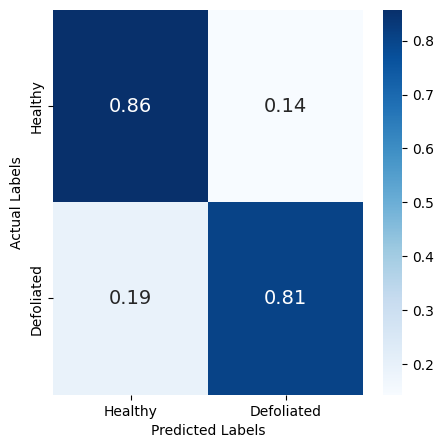

In [ ]:
#For fully trained
cm = confusion_matrix(preds_ft, actual_ft, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#Fully trained

print(f1_score(actual_conv, preds_conv, average="binary"))
print(precision_score(actual_conv, preds_conv, average="binary"))
print(recall_score(actual_conv, preds_conv, average="binary"))  

0.8342399083882048
0.8112472160356348
0.858573954036535
